# ENSF 519.01 Applied Data Science 
**Final Project - Prediciting Alberta Natural Gas Prices using Machine Learning**

**Due:** Sometime in December


**Team Members:**
James Bews,
Kendal Blais,
Tevin Schmidt,
Peter Schulze,

**Phase I:** Collect, Integrate and Clean data


**Data Collection**

In [1]:
import pandas as pd

# aggregate consumption
cad_data = pd.read_csv('CAD_NatGasSupply_Monthly.csv', thousands=',').rename(columns={'Month': 'Date'}).set_index('Date') # volumes in cubic meters
us_prod_data = pd.read_csv('US_NatGasProd_Monthly.csv').set_index('Date') # volumes in MMcf
us_demand_data = pd.read_csv('US_NatGasDemand_Monthly.csv').set_index('Date').dropna() # volumes in MMcf
price_data = pd.read_csv('US_CAN_NatGas_Prices.csv').set_index('Date') # prices in USD


In [2]:
from bs4 import BeautifulSoup
import requests

storage_stats_url = 'https://www150.statcan.gc.ca/t1/tbl1/en/cv!recreate.action?pid=2510005701&selectedNodeIds=2D2,3D1&checkedLevels=0D1&refPeriods=20160101,20190801&dimensionLayouts=layout2,layout3,layout2,layout2&vectorDisplay=false'

def get_page_html(url):
    return requests.get(url,timeout=10)

storage_stats_html = get_page_html(storage_stats_url).content
storage_stats_html

b'<!DOCTYPE html>\r\n<html class="no-js" lang="en" dir="ltr" xmlns="http://www.w3.org/1999/xhtml">\r\n  <head>\r\n<meta charset="utf-8">\r\n<base href="https://www150.statcan.gc.ca/t1/tbl1/" /><title>\r\n    Add/Remove data - Canadian natural gas storage, Canada and provinces, monthly</title>\r\n <link rel="schema.dcterms" href="http://purl.org/dc/terms/"/>\r\n<meta name="description" content="Natural gas storage opening and closing inventories, injections, withdrawals and adjustments reported in gigajoules and cubic metres, monthly, January 2016 to present." />\r\n<meta name="keywords" content="" />\r\n<meta name="dcterms.title" content="Add/Remove data - Canadian natural gas storage, Canada and provinces, monthly"/>\r\n<meta name="dcterms.language" title="ISO639-2" content="eng" />\r\n<meta name="dcterms.issued" title="W3CDTF" content="2018-04-04" />\r\n<meta name="dcterms.modified" title="W3CDTF" content="2019-10-25" />\r\n<meta name="dcterms.subject" title="gcstc" content="none" />

In [3]:

parser = BeautifulSoup(storage_stats_html, 'html.parser')

column_name_selector = '.pub-table .uom-center.bold'
columns = list(map(lambda elem: elem.text, parser.select(column_name_selector)))[2:]

row_name_selector = '.pub-table .highlight-row .align-right'
row = list(map(lambda elem: [float(elem.text.replace(',', ''))], parser.select(row_name_selector)))

storage_stats_dict = dict(zip(columns, row))
storage_stats_df = pd.DataFrame(storage_stats_dict)
# storage_stats_df contains closing inventory of a given month in cubic meters
storage_stats_df

,January 2016,February 2016,March 2016,April 2016,May 2016,June 2016,July 2016,August 2016,September 2016,October 2016,...,November 2018,December 2018,January 2019,February 2019,March 2019,April 2019,May 2019,June 2019,July 2019,August 2019
0,22220401.0,20472652.0,21006678.0,21036484.0,22392448.0,23743852.0,24585440.0,26122336.0,27420813.0,27234246.0,...,24072620.0,22871032.0,19196970.0,15318116.0,13874110.0,14142153.0,15744979.0,17643177.0,19187741.0,21098047.0


**Data Preparation**

- Canadian demand need to be agregated
- Volumes must be converted to MMcf
- USD must be convetred to CAD


In [4]:
# Aggregate CAD Consumption
cad_data['CAD Natural Gas Consumption'] = cad_data['Residential consumption']+cad_data['Commercial consumption']+cad_data['Industrial consumption']
cad_data = cad_data.drop(['Gross withdrawals','Imports','Residential consumption', 'Industrial consumption', 'Commercial consumption', 'Exports', 'Opening inventory', 'Closing inventory', 'Inventory change'], axis=1)
cad_data

,Marketable production,CAD Natural Gas Consumption
Date,,
Jan-16,14289542.7,11065298.7
Feb-16,13607932.1,9863883.1
Mar-16,14421808.5,9690121.5
Apr-16,13104382.7,7982794.7
May-16,14139484.9,6616912.9
Jun-16,13477340.2,7354024.2
Jul-16,13928637.2,7725783.2
Aug-16,14248386.5,7710188.5
Sep-16,13546045.8,6258890.8


In [14]:
# Convert volumes 

# cubic meters to cubic feet -> 35.3146667
# divide by 1 million to convert cubic feet to MMcf
# times by 1000 because the Canadian data was given to us with a scale of 1000 
cm_to_mmcf = 35.3146667 / 1000000 * 1000
# First convert storage_stats_df from cubic meters to MMcf
conv_cad_storage = storage_stats_df.apply(lambda x: x * cm_to_mmcf)

# Second convert price_data from USD to CAD
conv_price_data = pd.DataFrame()
conv_price_data['AECO (CAD/MMBtu)'] = price_data.apply(
    lambda x: x['AECO (USD/MMBtu)'] / x['CADUSD'], axis=1)
conv_price_data['AECO (CAD/GJ)'] = conv_price_data.apply(
    lambda x: x['AECO (CAD/MMBtu)'] * 1.055056, axis=1)

# Third convert cad_data from cubic meters to MMcf
conv_cad_data = cad_data.apply(lambda x: x * cm_to_mmcf)

**Data Exploration**

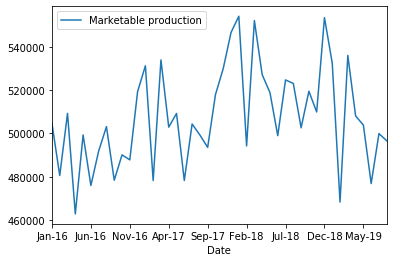

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

ax = plt.gca()
conv_cad_data.plot(kind='line', y='Marketable production', ax=ax)
plt.show()

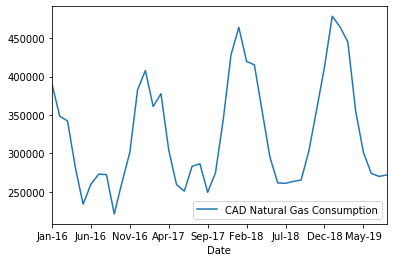

In [7]:
ax = plt.gca()
conv_cad_data.plot(kind='line', y='CAD Natural Gas Consumption', ax=ax)
plt.show()

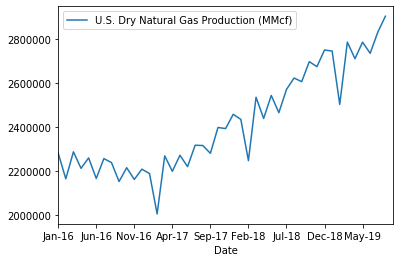

In [8]:
#US Production
ax = plt.gca()
us_prod_data.plot(kind='line', y='U.S. Dry Natural Gas Production (MMcf)', ax=ax)
plt.show()

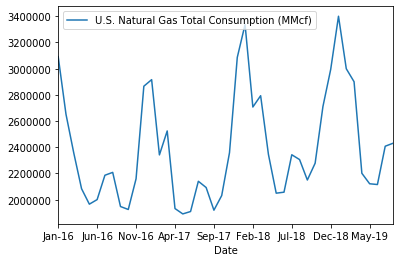

In [9]:
#US Demand
ax = plt.gca()
us_demand_data.plot(kind='line', y='U.S. Natural Gas Total Consumption (MMcf)', ax=ax)
plt.show()

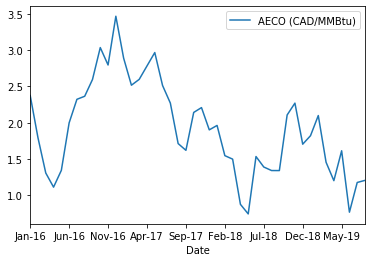

In [10]:
# AECO Nat Gas Pricing
ax = plt.gca()
conv_price_data.plot(kind='line', y='AECO (CAD/MMBtu)', ax=ax)
plt.show()

**Data Prediction**